Playing with XGBoost

In [1]:
import xgboost as xgb

In [2]:
import numpy as np
import pandas as pd

In [3]:
og_df = pd.read_csv("train.csv")

In [4]:
# perhaps cross validation could be better.. 

In [5]:
# smaller df to start testing on
df = og_df.iloc[:100, :20]
df = df.drop(columns='ID_code') # note highly unbalanced dataset

In [6]:
#  turn it into a dmatrix?!
dtrain = xgb.DMatrix(df.drop(columns='target'), label = df['target'])

In [7]:
dtest = og_df.iloc[100:120, :20]
dtest = dtest.drop(columns='ID_code')
dtest = xgb.DMatrix(dtest.drop(columns='target'), label = dtest['target'])

In [8]:
param = {'max_depth': 2, 'eta': 0.3, 'objective': 'binary:logistic'}
param['nthread'] = 4
param['eval_metric'] = ['auc', 'logloss']

In [11]:
evals_result = {}
num_round = 10
watchlist = [(dtest, "eval"), (dtrain, "train")]
bst = xgb.train(param, dtrain, num_round, evals=watchlist, evals_result = evals_result)

[0]	eval-auc:0.39474	eval-logloss:0.24670	train-auc:0.87840	train-logloss:0.26380
[1]	eval-auc:0.39474	eval-logloss:0.23128	train-auc:0.90625	train-logloss:0.23487
[2]	eval-auc:0.34211	eval-logloss:0.22471	train-auc:0.96535	train-logloss:0.21521
[3]	eval-auc:0.28947	eval-logloss:0.22579	train-auc:0.99185	train-logloss:0.19197
[4]	eval-auc:0.47368	eval-logloss:0.22104	train-auc:1.00000	train-logloss:0.16936
[5]	eval-auc:0.52632	eval-logloss:0.21255	train-auc:0.99864	train-logloss:0.15787
[6]	eval-auc:0.52632	eval-logloss:0.21815	train-auc:1.00000	train-logloss:0.14386
[7]	eval-auc:0.52632	eval-logloss:0.22371	train-auc:1.00000	train-logloss:0.12998
[8]	eval-auc:0.52632	eval-logloss:0.22593	train-auc:1.00000	train-logloss:0.11713
[9]	eval-auc:0.47368	eval-logloss:0.23263	train-auc:1.00000	train-logloss:0.10745


In [12]:
preds = bst.predict(dtest) > 0.5
mysum = 0
for i in range(len(dtest.get_label())):
    if int(preds[i]) == dtest.get_label()[i]:
        mysum += 1

<AxesSubplot: >

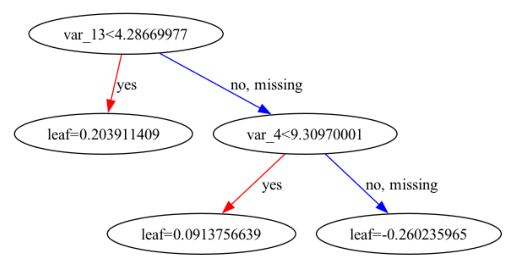

In [14]:
# note that the tree plotted isn't the overall decision boundary - it's one of 10 trees
xgb.plot_tree(bst, num_trees = 2)

<AxesSubplot: >

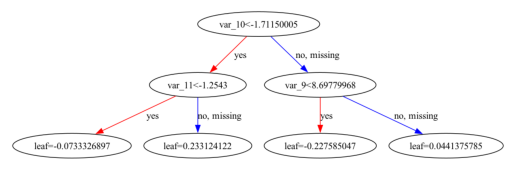

In [15]:
xgb.plot_tree(bst[9][0])

In [16]:
import matplotlib.pyplot as plt

In [17]:
label0 = df[df['target'] == 0]
label1 = df[df['target'] == 1]

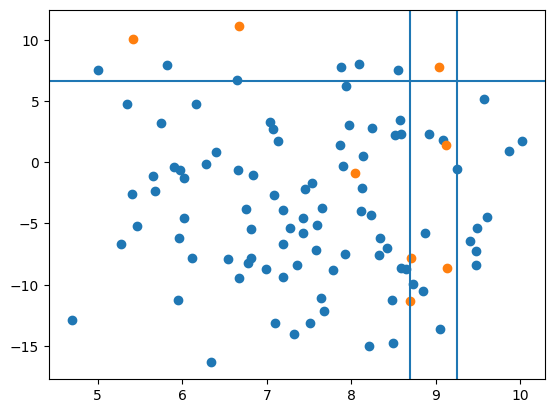

In [18]:
plt.scatter(label0['var_9'], label0['var_11'])
plt.scatter(label1['var_9'], label1['var_11'])
plt.axhline(y=6.67)
plt.axvline(x=8.6978)
plt.axvline(x=9.250)

<AxesSubplot: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

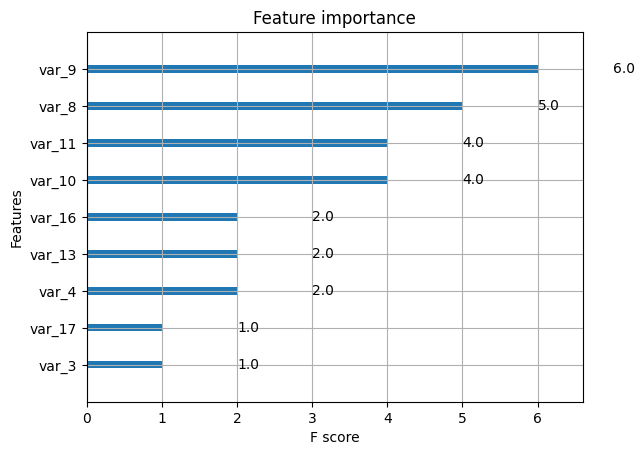

In [19]:
xgb.plot_importance(bst)

tests using the scikit learn interface

In [20]:
clf = xgb.XGBClassifier()

In [21]:
clf.fit(df.drop(columns='target'), df['target'])

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [22]:
preds = clf.predict(df.drop(columns='target'))
sum(preds == df['target']) # weow!

In [25]:
from sklearn.model_selection import cross_validate
from sklearn.metrics import log_loss

In [28]:
cross_validate(xgb.XGBClassifier(), df.drop(columns='target'), y=df['target'], cv = 5)

{'fit_time': array([0.02990317, 0.01743722, 0.01925588, 0.01893115, 0.01568604]),
 'score_time': array([0.00203896, 0.00166512, 0.00163221, 0.00156903, 0.00179005]),
 'test_score': array([0.95, 0.95, 0.9 , 0.9 , 0.9 ])}

ok now try on the whole dataset

In [30]:
from sklearn.model_selection import train_test_split

In [32]:
og_df.iloc[:,2:]

,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,8.9255,-6.7863,11.9081,5.0930,11.4607,-9.2834,5.1187,18.6266,-4.9200,5.7470,...,4.4354,3.9642,3.1364,1.6910,18.5227,-2.3978,7.8784,8.5635,12.7803,-1.0914
1,11.5006,-4.1473,13.8588,5.3890,12.3622,7.0433,5.6208,16.5338,3.1468,8.0851,...,7.6421,7.7214,2.5837,10.9516,15.4305,2.0339,8.1267,8.7889,18.3560,1.9518
2,8.6093,-2.7457,12.0805,7.8928,10.5825,-9.0837,6.9427,14.6155,-4.9193,5.9525,...,2.9057,9.7905,1.6704,1.6858,21.6042,3.1417,-6.5213,8.2675,14.7222,0.3965
3,11.0604,-2.1518,8.9522,7.1957,12.5846,-1.8361,5.8428,14.9250,-5.8609,8.2450,...,4.4666,4.7433,0.7178,1.4214,23.0347,-1.2706,-2.9275,10.2922,17.9697,-8.9996
4,9.8369,-1.4834,12.8746,6.6375,12.2772,2.4486,5.9405,19.2514,6.2654,7.6784,...,-1.4905,9.5214,-0.1508,9.1942,13.2876,-1.5121,3.9267,9.5031,17.9974,-8.8104
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199995,11.4880,-0.4956,8.2622,3.5142,10.3404,11.6081,5.6709,15.1516,-0.6209,5.6669,...,6.1415,13.2305,3.9901,0.9388,18.0249,-1.7939,2.1661,8.5326,16.6660,-17.8661
199996,4.9149,-2.4484,16.7052,6.6345,8.3096,-10.5628,5.8802,21.5940,-3.6797,6.0019,...,4.9611,4.6549,0.6998,1.8341,22.2717,1.7337,-2.1651,6.7419,15.9054,0.3388
199997,11.2232,-5.0518,10.5127,5.6456,9.3410,-5.4086,4.5555,21.5571,0.1202,6.1629,...,4.0651,5.4414,3.1032,4.8793,23.5311,-1.5736,1.2832,8.7155,13.8329,4.1995
199998,9.7148,-8.6098,13.6104,5.7930,12.5173,0.5339,6.0479,17.0152,-2.1926,8.7542,...,2.6840,8.6587,2.7337,11.1178,20.4158,-0.0786,6.7980,10.0342,15.5289,-13.9001


In [35]:
X_train, X_test, y_train, y_test = train_test_split(og_df.iloc[:,2:], 
                                                    og_df.iloc[:,1], 
                                                    test_size = 0.2)


In [49]:
clf = xgb.XGBClassifier(objective = 'binary:logistic', n_estimators = 100)

In [50]:
clf.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [51]:
preds = clf.predict(X_test)
sum(preds == y_test)/len(y_test)

0.9122

In [52]:
preds = clf.predict(X_train)
sum(preds==y_train)/len(y_train)

0.959525